# Time Series Analysis: Cambodia Rainfall Forecasting

**Course:** Time Series Analysis  
**Group:** 01  
**Instructor:** Dr. SIM Tepmony  
**Date:** January 2026

---

## ✅ Corrected Version - All Modern APIs

This notebook uses:

- ✅ Modern `statsmodels.tsa.arima.model.ARIMA` and `SARIMAX` (no deprecated `disp` parameter)
- ✅ Proper train-test split (no data leakage)
- ✅ Out-of-sample rolling forecasts for evaluation
- ✅ Seasonal decomposition and seasonal differencing
- ✅ Residual diagnostics (ACF, Ljung-Box, normality tests)
- ✅ Model comparison with proper metrics

---

## Table of Contents

1. Import Libraries
2. Data Loading and Exploration
3. Data Preprocessing and Monthly Aggregation
4. Exploratory Data Analysis (EDA)
5. Time Series Decomposition
6. Stationarity Testing (ADF)
7. Seasonal Differencing
8. ACF and PACF Analysis
9. Train-Test Split (No Leakage)
10. Model Fitting with Out-of-Sample Evaluation
    - AR Models
    - MA Models
    - ARMA Models
    - ARIMA Models
    - SARIMA Models
11. Model Comparison
12. Residual Diagnostics
13. Final Forecasting
14. Conclusions


---

## 1. Import Libraries

All modern APIs - no deprecated functions.


In [ ]:
import warnings

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# Time series analysis - MODERN APIs only
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA  # Modern ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Modern SARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

# >>> add these imports <<<
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning

# Machine learning metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set random seed
np.random.seed(42)

# Suppress specific statsmodels warnings
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import warnings
import statsmodels

warnings.filterwarnings("ignore")


# Completely silence all UserWarning coming from statsmodels
warnings.filterwarnings(
    "ignore", category=UserWarning, module=r"statsmodels\.tsa\.statespace\.sarimax"
)

---

## 2. Data Loading and Initial Exploration

### Mathematical Background: Time Series Definition

A **time series** is a sequence of observations $ y_t $ indexed by time $ t $, where $ t = 1, 2, \ldots, T $.

$$ y_t = f(t) + \varepsilon_t $$

where:

- $ f(t) $ represents the systematic component (trend + seasonality)
- $ \varepsilon_t $ represents random noise (white noise)

**Key Properties:**

1. Mean: $ \mu_t = \mathbb{E}[y_t] $
2. Variance: $ \sigma^2_t = \mathrm{Var}(y_t) $
3. Autocovariance: $ \gamma(s,t) = \mathrm{Cov}(y_s, y_t) $


In [2]:
# Load Cambodia rainfall dataset from HDX
url = "https://data.humdata.org/dataset/8fa90d2b-a88e-414d-84a1-50d6bc773542/resource/67c4f3d6-f600-4699-9a67-0de20d6a1b0b/download/khm-rainfall-subnat-full.csv"

print("Loading Cambodia rainfall dataset...")
df_raw = pd.read_csv(url)
print(f"✓ Dataset loaded successfully!")
print(f"Shape: {df_raw.shape}")
print(f"\nFirst few rows:")
df_raw.head()

Loading Cambodia rainfall dataset...
✓ Dataset loaded successfully!
Shape: (358241, 15)

First few rows:


,date,adm_level,adm_id,PCODE,n_pixels,rfh,rfh_avg,r1h,r1h_avg,r3h,r3h_avg,rfq,r1q,r3q,version
0,1981-01-01,1,900411,KH15,2.0,1.0,2.400000,NaN,NaN,NaN,NaN,81.081080,NaN,NaN,final
1,1981-01-11,1,900411,KH15,2.0,0.5,1.000000,NaN,NaN,NaN,NaN,91.666670,NaN,NaN,final
2,1981-01-21,1,900411,KH15,2.0,3.0,2.250000,4.5,5.650000,NaN,NaN,110.344826,89.20188,NaN,final
3,1981-02-01,1,900411,KH15,2.0,4.5,2.483333,8.0,5.733333,NaN,NaN,126.948780,121.11801,NaN,final
4,1981-02-11,1,900411,KH15,2.0,4.5,4.150000,12.0,8.883333,NaN,NaN,103.825140,122.44898,NaN,final


In [3]:
# Dataset information
print("=" * 60)
print("Dataset Information")
print("=" * 60)
df_raw.info()
print("\n" + "=" * 60)
print("Summary Statistics")
print("=" * 60)
df_raw.describe()

Dataset Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358241 entries, 0 to 358240
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       358241 non-null  object 
 1   adm_level  358241 non-null  int64  
 2   adm_id     358241 non-null  int64  
 3   PCODE      358241 non-null  object 
 4   n_pixels   358241 non-null  float64
 5   rfh        358241 non-null  float64
 6   rfh_avg    358241 non-null  float64
 7   r1h        357799 non-null  float64
 8   r1h_avg    357799 non-null  float64
 9   r3h        356473 non-null  float64
 10  r3h_avg    356473 non-null  float64
 11  rfq        358241 non-null  float64
 12  r1q        357799 non-null  float64
 13  r3q        356473 non-null  float64
 14  version    358241 non-null  object 
dtypes: float64(10), int64(2), object(3)
memory usage: 41.0+ MB

Summary Statistics


,adm_level,adm_id,n_pixels,rfh,rfh_avg,r1h,r1h_avg,r3h,r3h_avg,rfq,r1q,r3q
count,358241.000000,3.582410e+05,358241.000000,358241.000000,358241.000000,357799.000000,357799.000000,356473.000000,356473.000000,358241.000000,357799.000000,356473.000000
mean,1.882353,9.938594e+05,53.918552,50.533208,50.446255,151.781830,151.475458,456.628298,455.553361,99.503847,99.195325,99.530930
std,0.322190,3.411807e+04,87.656551,53.591433,44.794200,142.794801,130.781864,369.396604,352.300300,48.516597,39.896489,31.625497
min,1.000000,9.004110e+05,1.000000,0.000000,0.000000,0.000000,0.019672,3.000000,14.302381,7.340091,6.648260,11.726528
25%,2.000000,1.006248e+06,11.000000,6.000000,11.220963,25.300001,35.766666,137.488890,148.483340,68.956610,74.300772,81.343100
50%,2.000000,1.006303e+06,22.000000,37.600000,43.526670,130.000000,137.500000,420.333300,427.566680,90.942500,94.072740,97.329310
75%,2.000000,1.006361e+06,50.000000,77.000000,77.346940,231.333320,229.926350,658.777800,644.513300,119.939100,116.974300,113.842650
max,2.000000,1.006416e+06,467.000000,803.608700,356.183320,1743.347900,941.975000,3548.782700,2363.883300,816.339500,511.743840,352.051330


---

## 3. Data Preprocessing and Monthly Aggregation

### Mathematical Background: Temporal Aggregation

When aggregating from daily/dekadal to monthly data:

$$ Y_m = \sum_{d \in m} y_d $$

where $ Y_m $ is total rainfall in month $ m $, and $ y_d $ is rainfall on day/dekad $ d $.

**Properties:**

- Reduces noise (smoothing effect)
- Captures longer-term patterns
- More suitable for seasonal modeling


In [4]:
# Convert date to datetime
df_raw["date"] = pd.to_datetime(df_raw["date"])

# Focus on provincial level (adm_level = 1)
df_province = df_raw[df_raw["adm_level"] == 1].copy()

print(f"Provincial-level records: {len(df_province)}")
print(f"Number of provinces: {df_province['PCODE'].nunique()}")
print(f"Provinces: {sorted(df_province['PCODE'].unique())}")

Provincial-level records: 42146
Number of provinces: 25
Provinces: ['KH01', 'KH02', 'KH03', 'KH04', 'KH05', 'KH06', 'KH07', 'KH08', 'KH09', 'KH10', 'KH11', 'KH12', 'KH13', 'KH14', 'KH15', 'KH16', 'KH17', 'KH18', 'KH19', 'KH20', 'KH21', 'KH22', 'KH23', 'KH24', 'KH25']


In [5]:
# Select province with most complete data
province_counts = df_province.groupby("PCODE").size()
selected_province = province_counts.idxmax()

print(f"Selected province: {selected_province}")
print(f"Records: {province_counts[selected_province]}")

df_selected = df_province[df_province["PCODE"] == selected_province].copy()
df_selected = df_selected.sort_values("date").reset_index(drop=True)
df_selected = df_selected[["date", "rfh"]].copy()
df_selected.columns = ["date", "rainfall"]

print(f"\nData range: {df_selected['date'].min()} to {df_selected['date'].max()}")
df_selected.head()

Selected province: KH15
Records: 3242

Data range: 1981-01-01 00:00:00 to 2026-01-01 00:00:00


,date,rainfall
0,1981-01-01,1.000000
1,1981-01-01,1.393782
2,1981-01-11,0.500000
3,1981-01-11,1.489637
4,1981-01-21,3.000000


In [6]:
# Handle missing values - modern pandas syntax
print("=" * 60)
print("Missing Value Analysis")
print("=" * 60)
print(f"Missing values: {df_selected['rainfall'].isna().sum()}")
print(
    f"Percentage: {df_selected['rainfall'].isna().sum() / len(df_selected) * 100:.2f}%"
)

# Use modern pandas methods (no deprecated 'method' parameter)
df_selected["rainfall"] = df_selected["rainfall"].ffill().bfill()

print(f"After imputation: {df_selected['rainfall'].isna().sum()}")

Missing Value Analysis
Missing values: 0
Percentage: 0.00%
After imputation: 0


In [7]:
# Aggregate to monthly
df_selected["year_month"] = df_selected["date"].dt.to_period("M")

df_monthly = df_selected.groupby("year_month").agg({"rainfall": "sum"}).reset_index()

df_monthly["date"] = df_monthly["year_month"].dt.to_timestamp()
df_monthly = df_monthly[["date", "rainfall"]].copy()

print("=" * 60)
print("Monthly Data")
print("=" * 60)
print(f"Total months: {len(df_monthly)}")
print(f"Range: {df_monthly['date'].min()} to {df_monthly['date'].max()}")
print(f"\nFirst rows:")
df_monthly.head(10)

Monthly Data
Total months: 541
Range: 1981-01-01 00:00:00 to 2026-01-01 00:00:00

First rows:


,date,rainfall
0,1981-01-01,17.272021
1,1981-02-01,76.948185
2,1981-03-01,53.823835
3,1981-04-01,149.800519
4,1981-05-01,333.725390
5,1981-06-01,569.883415
6,1981-07-01,589.834190
7,1981-08-01,582.481870
8,1981-09-01,486.427453
9,1981-10-01,472.746120


In [8]:
# Create time series
ts_data = df_monthly.set_index("date")["rainfall"]
ts_data = ts_data.asfreq("MS")

print(f"\nTime series shape: {ts_data.shape}")
print(f"Frequency: {ts_data.index.freq}")
ts_data.head()


Time series shape: (541,)
Frequency: <MonthBegin>


date
1981-01-01     17.272021
1981-02-01     76.948185
1981-03-01     53.823835
1981-04-01    149.800519
1981-05-01    333.725390
Freq: MS, Name: rainfall, dtype: float64

---

## 4. Exploratory Data Analysis (EDA)

### Mathematical Background: Descriptive Statistics

For time series $ \{y*t\}*{t=1}^{T} $:

**Sample Mean:**  
$$ \bar{y} = \frac{1}{T} \sum\ _{t=1}^{T} y_t $$

**Sample Variance:**  
$$ s^2 = \frac{1}{T-1} \sum\ _{t=1}^{T} (y_t - \bar{y})^2 $$

**Coefficient of Variation:**  
$$ CV = \frac{s}{\bar{y}} \times 100\% $$

**Skewness:**  
$$ \text{Skew} = \frac{1}{T} \sum\ _{t=1}^{T} \left(\frac{y_t - \bar{y}}{s}\right)^3 $$

**Kurtosis:**  
$$ \text{Kurt} = \frac{1}{T} \sum\ _{t=1}^{T} \left(\frac{y_t - \bar{y}}{s}\right)^4 $$


In [9]:
# Descriptive statistics
print("=" * 60)
print("Descriptive Statistics")
print("=" * 60)
stats = {
    "Count": len(ts_data),
    "Mean": ts_data.mean(),
    "Median": ts_data.median(),
    "Std Dev": ts_data.std(),
    "Variance": ts_data.var(),
    "Min": ts_data.min(),
    "Max": ts_data.max(),
    "Range": ts_data.max() - ts_data.min(),
    "Q1": ts_data.quantile(0.25),
    "Q3": ts_data.quantile(0.75),
    "IQR": ts_data.quantile(0.75) - ts_data.quantile(0.25),
    "CV (%)": (ts_data.std() / ts_data.mean()) * 100,
    "Skewness": ts_data.skew(),
    "Kurtosis": ts_data.kurtosis(),
}

for key, value in stats.items():
    print(f"{key:15s}: {value:10.4f}")

Descriptive Statistics
Count          :   541.0000
Mean           :   306.2502
Median         :   308.3109
Std Dev        :   239.4916
Variance       : 57356.2467
Min            :     0.0104
Max            :   958.9870
Range          :   958.9767
Q1             :    55.2539
Q3             :   501.9611
IQR            :   446.7072
CV (%)         :    78.2013
Skewness       :     0.3308
Kurtosis       :    -1.0155


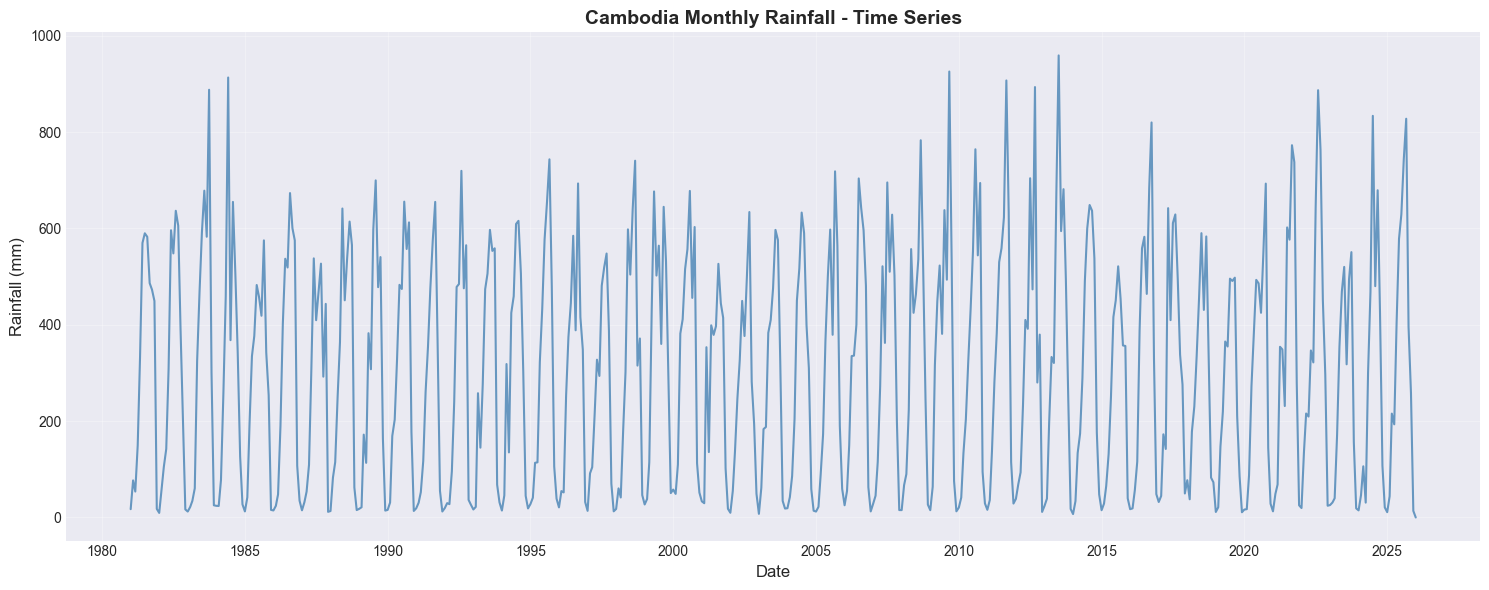

✓ Saved: timeseries_plot.png


In [10]:
# Time series plot
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(ts_data.index, ts_data.values, linewidth=1.5, color="steelblue", alpha=0.8)
ax.set_title("Cambodia Monthly Rainfall - Time Series", fontsize=14, fontweight="bold")
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Rainfall (mm)", fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("timeseries_plot.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved: timeseries_plot.png")

---

## 5. Time Series Decomposition

### Mathematical Background: Additive Decomposition

$$ y_t = T_t + S_t + R_t $$

where:

- $ T_t $ = Trend component
- $ S_t $ = Seasonal component
- $ R_t $ = Residual (irregular) component

**Seasonal Period:** $ s = 12 $ months (annual seasonality)


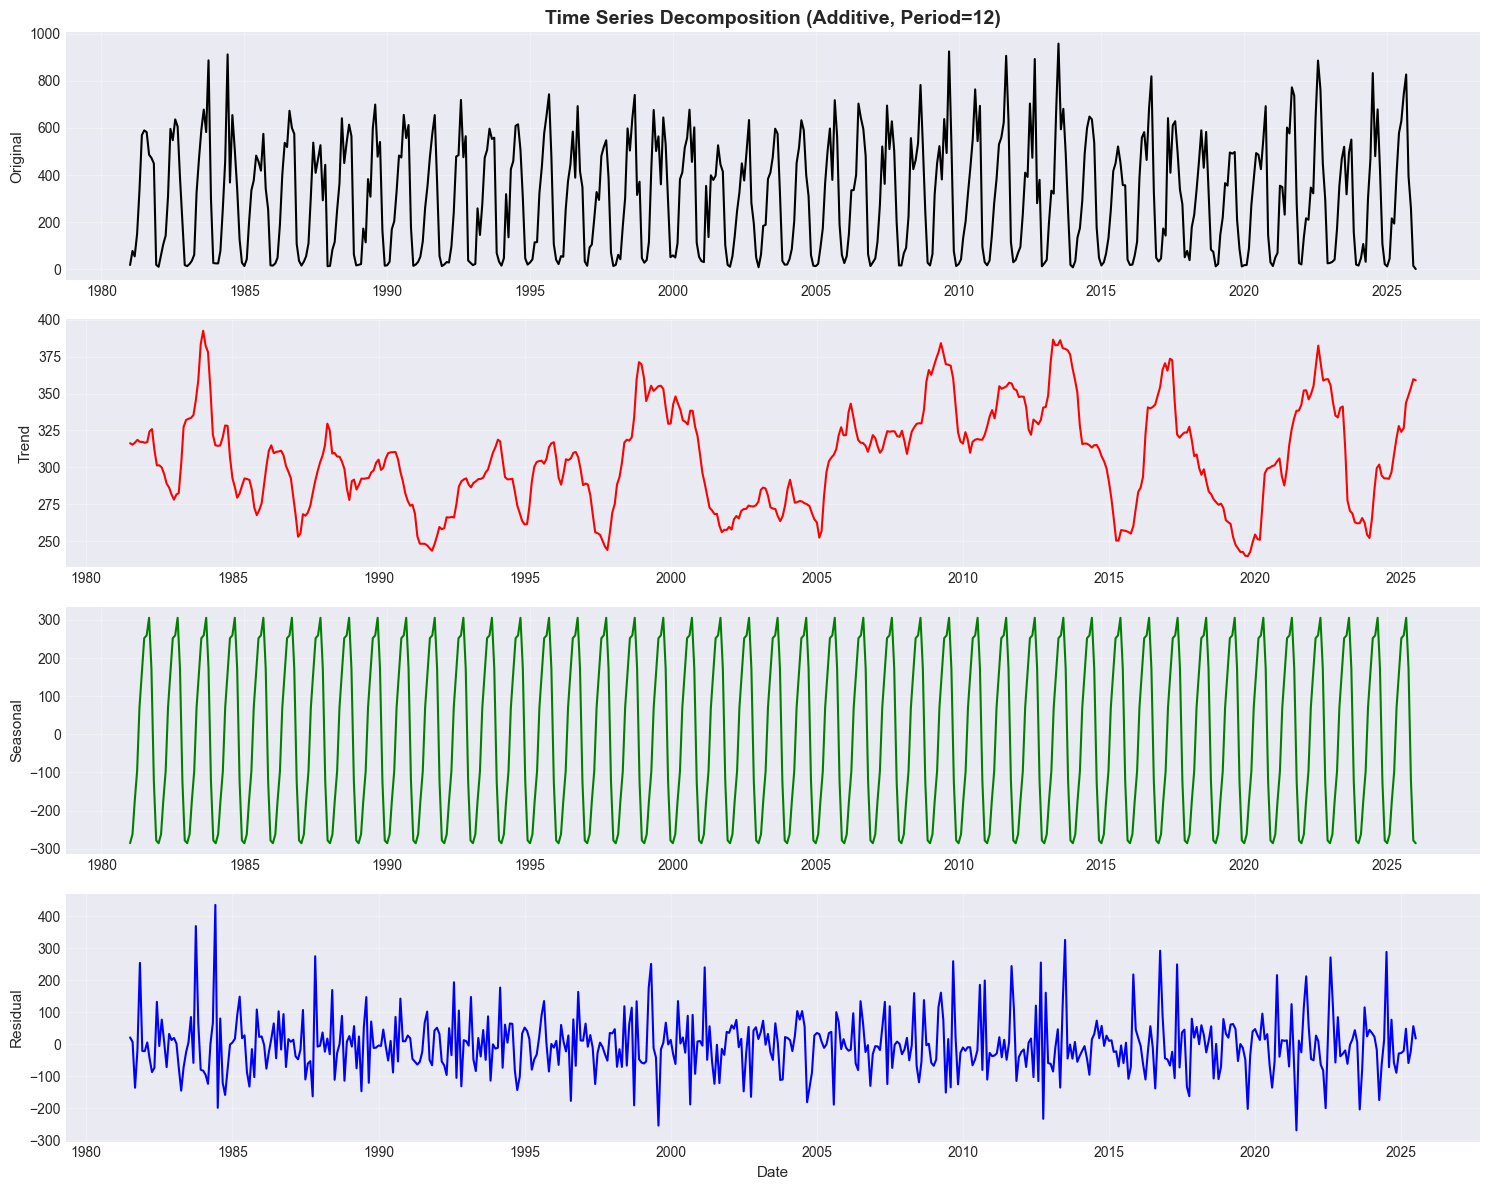

✓ Saved: decomposition.png


In [11]:
# Seasonal decomposition
decomposition = seasonal_decompose(ts_data, model="additive", period=12)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Original
axes[0].plot(ts_data, linewidth=1.5, color="black")
axes[0].set_ylabel("Original", fontsize=11)
axes[0].set_title(
    "Time Series Decomposition (Additive, Period=12)", fontsize=14, fontweight="bold"
)
axes[0].grid(True, alpha=0.3)

# Trend
axes[1].plot(decomposition.trend, linewidth=1.5, color="red")
axes[1].set_ylabel("Trend", fontsize=11)
axes[1].grid(True, alpha=0.3)

# Seasonal
axes[2].plot(decomposition.seasonal, linewidth=1.5, color="green")
axes[2].set_ylabel("Seasonal", fontsize=11)
axes[2].grid(True, alpha=0.3)

# Residual
axes[3].plot(decomposition.resid, linewidth=1.5, color="blue")
axes[3].set_ylabel("Residual", fontsize=11)
axes[3].set_xlabel("Date", fontsize=11)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("decomposition.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved: decomposition.png")

---

## 6. Stationarity Testing (ADF Test)

### Mathematical Background: Augmented Dickey-Fuller Test

**Null Hypothesis (H₀):** The series has a unit root (non-stationary)  
**Alternative Hypothesis (H₁):** The series is stationary

**Test Statistic:**  
$$ \Delta y*t = \alpha + \beta t + \gamma y*{t-1} + \sum*{i=1}^{p} \delta_i \Delta y*{t-i} + \varepsilon_t $$

**Decision Rule:**

- If p-value < 0.05: Reject H₀ (series is stationary)
- If p-value ≥ 0.05: Fail to reject H₀ (series is non-stationary)


In [12]:
def adf_test(series, name="Series"):
    """Perform Augmented Dickey-Fuller test"""
    result = adfuller(series.dropna(), autolag="AIC")

    print(f"\n{'='*60}")
    print(f"ADF Test Results: {name}")
    print(f"{'='*60}")
    print(f"ADF Statistic:     {result[0]:.6f}")
    print(f"p-value:           {result[1]:.6f}")
    print(f"# Lags Used:       {result[2]}")
    print(f"# Observations:    {result[3]}")

    print(f"\nCritical Values:")
    for key, value in result[4].items():
        print(f"  {key:5s}: {value:.3f}")

    if result[1] < 0.05:
        print(
            f"\n✓ Conclusion: Series is STATIONARY (p-value = {result[1]:.6f} < 0.05)"
        )
    else:
        print(
            f"\n✗ Conclusion: Series is NON-STATIONARY (p-value = {result[1]:.6f} ≥ 0.05)"
        )

    return result


# Test original series
adf_result_original = adf_test(ts_data, "Original Series")


ADF Test Results: Original Series
ADF Statistic:     -5.030478
p-value:           0.000019
# Lags Used:       17
# Observations:    523

Critical Values:
  1%   : -3.443
  5%   : -2.867
  10%  : -2.570

✓ Conclusion: Series is STATIONARY (p-value = 0.000019 < 0.05)


---

## 7. Seasonal Differencing

### Mathematical Background: Seasonal Difference

$$ \nabla*s y_t = y_t - y*{t-s} $$

where $ s = 12 $ (seasonal period)

This removes seasonal patterns and helps achieve stationarity.


In [13]:
# Seasonal differencing (lag = 12)
ts_seasonal_diff = ts_data.diff(12)

# Test stationarity after seasonal differencing
adf_result_seasonal = adf_test(
    ts_seasonal_diff, "Seasonally Differenced Series (lag=12)"
)


ADF Test Results: Seasonally Differenced Series (lag=12)
ADF Statistic:     -9.726492
p-value:           0.000000
# Lags Used:       11
# Observations:    517

Critical Values:
  1%   : -3.443
  5%   : -2.867
  10%  : -2.570

✓ Conclusion: Series is STATIONARY (p-value = 0.000000 < 0.05)


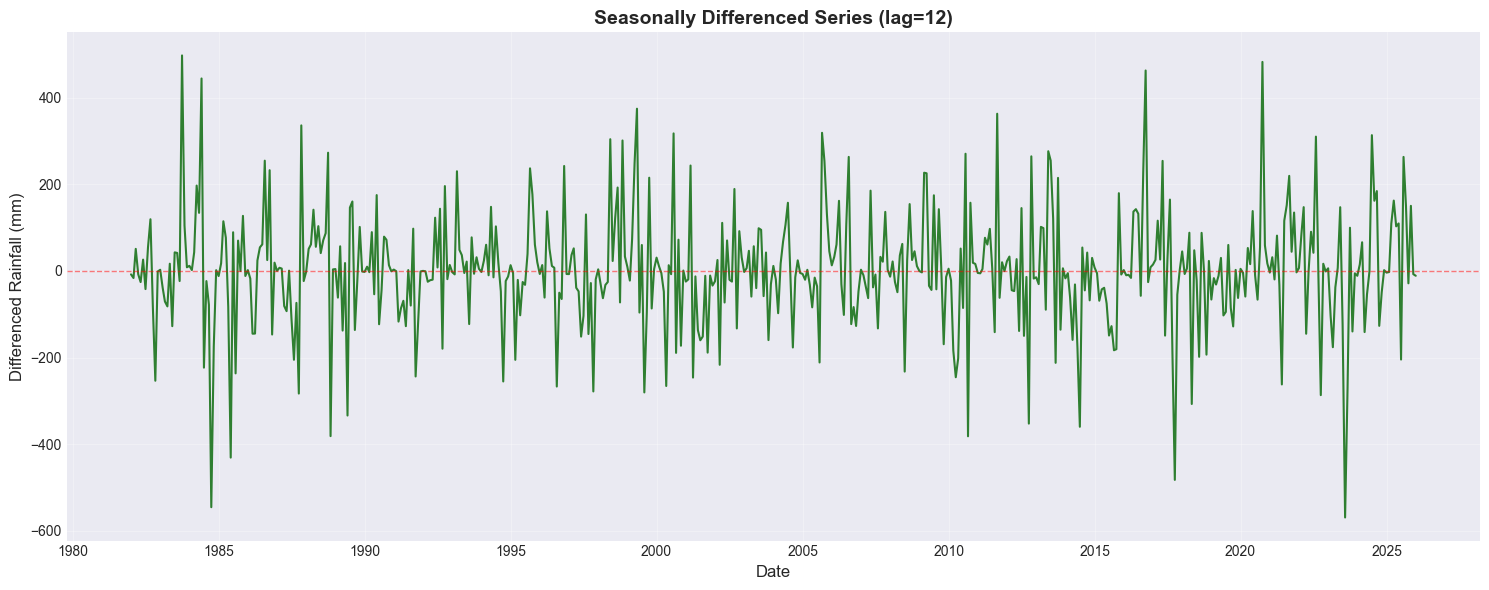

✓ Saved: seasonal_differencing.png


In [14]:
# Plot seasonally differenced series
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(ts_seasonal_diff, linewidth=1.5, color="darkgreen", alpha=0.8)
ax.axhline(y=0, color="red", linestyle="--", linewidth=1, alpha=0.5)
ax.set_title("Seasonally Differenced Series (lag=12)", fontsize=14, fontweight="bold")
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Differenced Rainfall (mm)", fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("seasonal_differencing.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved: seasonal_differencing.png")

---

## 8. ACF and PACF Analysis

### Mathematical Background

**Autocorrelation Function (ACF):**  
$$ \rho(k) = \frac{\mathrm{Cov}(y*t, y*{t-k})}{\mathrm{Var}(y_t)} $$

**Partial Autocorrelation Function (PACF):**  
The correlation between $ y*t $ and $ y*{t-k} $ after removing the effect of intermediate lags.

**Model Identification:**

- **AR(p)**: PACF cuts off after lag $ p $, ACF decays
- **MA(q)**: ACF cuts off after lag $ q $, PACF decays
- **ARMA(p,q)**: Both ACF and PACF decay


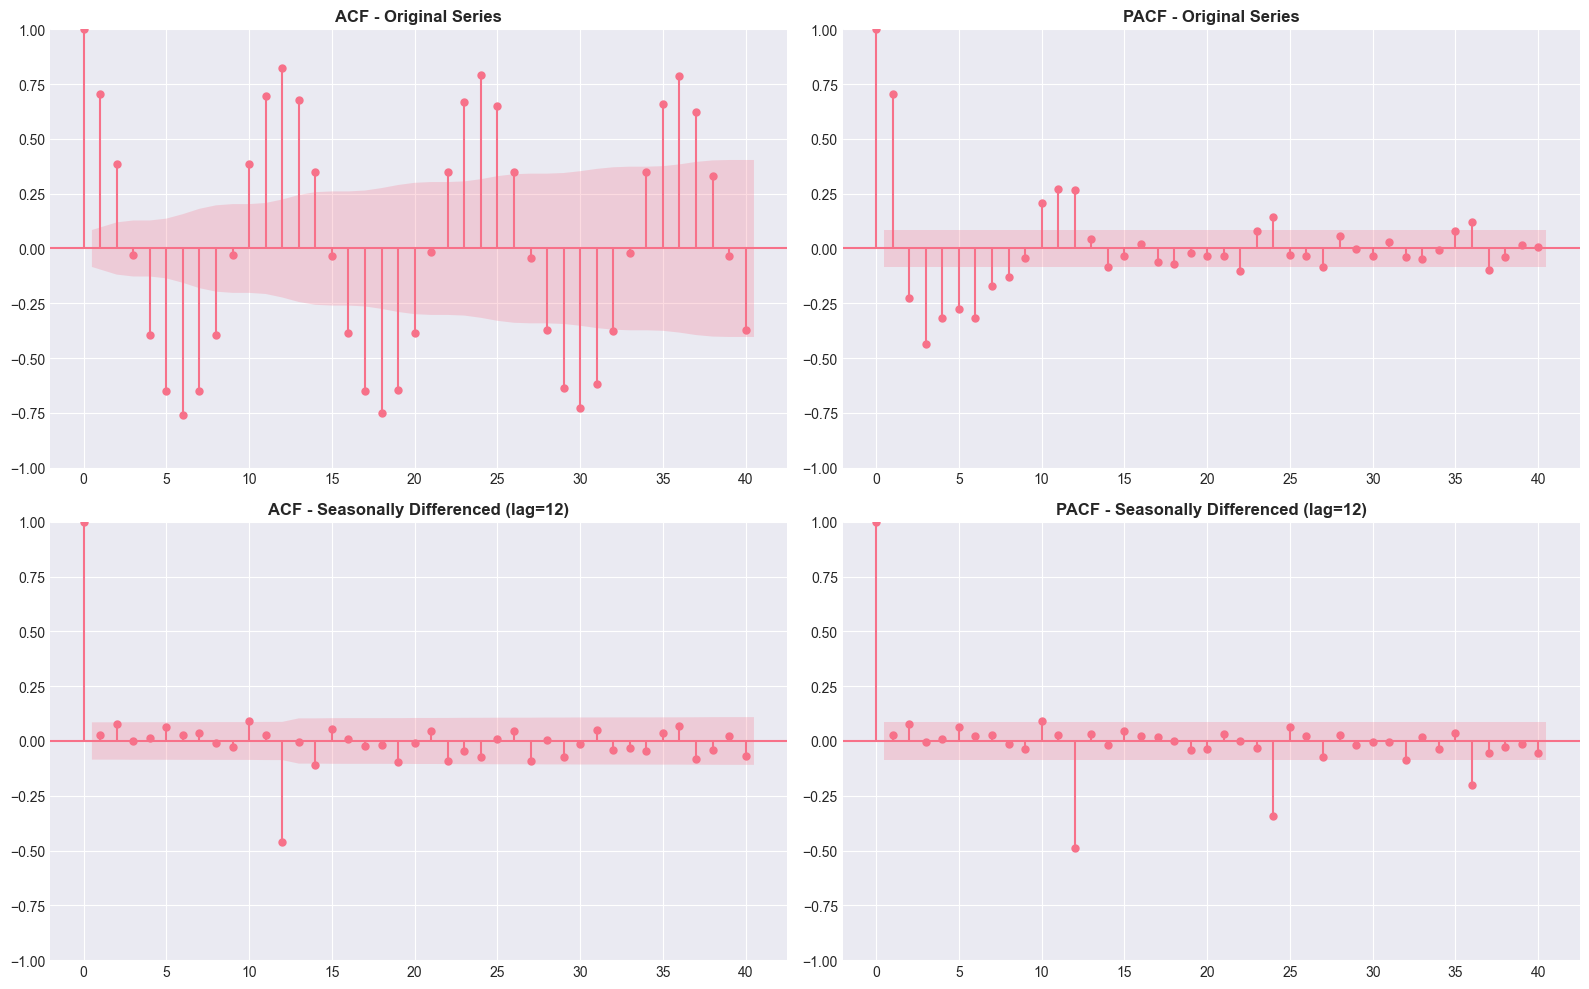

✓ Saved: acf_pacf.png


In [15]:
# ACF and PACF plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Original series
plot_acf(ts_data.dropna(), lags=40, ax=axes[0, 0])
axes[0, 0].set_title("ACF - Original Series", fontsize=12, fontweight="bold")

plot_pacf(ts_data.dropna(), lags=40, ax=axes[0, 1])
axes[0, 1].set_title("PACF - Original Series", fontsize=12, fontweight="bold")

# Seasonally differenced series
plot_acf(ts_seasonal_diff.dropna(), lags=40, ax=axes[1, 0])
axes[1, 0].set_title(
    "ACF - Seasonally Differenced (lag=12)", fontsize=12, fontweight="bold"
)

plot_pacf(ts_seasonal_diff.dropna(), lags=40, ax=axes[1, 1])
axes[1, 1].set_title(
    "PACF - Seasonally Differenced (lag=12)", fontsize=12, fontweight="bold"
)

plt.tight_layout()
plt.savefig("acf_pacf.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved: acf_pacf.png")

---

## 9. Train-Test Split (No Data Leakage)

### ✅ Correct Approach: Temporal Split

To prevent **data leakage**, we split the data temporally:

- **Train set:** Earlier observations (for model fitting)
- **Test set:** Later observations (for out-of-sample evaluation)

We use the **last 60 months (~5 years)** as the test set.


In [16]:
# Define test horizon
test_horizon = 60  # Last 5 years for testing

# Split data
train_data = ts_data.iloc[:-test_horizon]
test_data = ts_data.iloc[-test_horizon:]

print("=" * 60)
print("Train-Test Split")
print("=" * 60)
print(
    f"Train: {train_data.index[0]} to {train_data.index[-1]} ({len(train_data)} months)"
)
print(f"Test:  {test_data.index[0]} to {test_data.index[-1]} ({len(test_data)} months)")
print(f"\nTrain set: {len(train_data)} observations")
print(f"Test set:  {len(test_data)} observations")
print(f"Total:     {len(ts_data)} observations")

Train-Test Split
Train: 1981-01-01 00:00:00 to 2021-01-01 00:00:00 (481 months)
Test:  2021-02-01 00:00:00 to 2026-01-01 00:00:00 (60 months)

Train set: 481 observations
Test set:  60 observations
Total:     541 observations


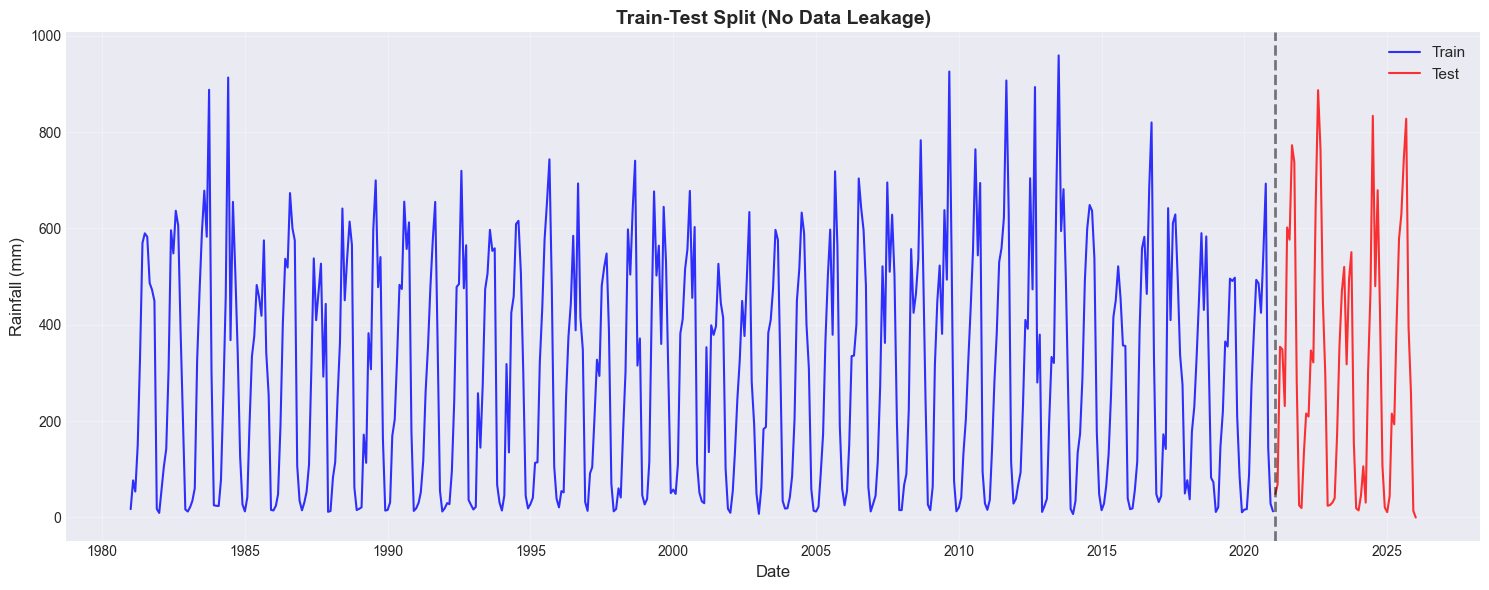

✓ Saved: train_test_split.png


In [17]:
# Visualize train-test split
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(
    train_data.index,
    train_data.values,
    linewidth=1.5,
    color="blue",
    label="Train",
    alpha=0.8,
)
ax.plot(
    test_data.index,
    test_data.values,
    linewidth=1.5,
    color="red",
    label="Test",
    alpha=0.8,
)
ax.axvline(x=test_data.index[0], color="black", linestyle="--", linewidth=2, alpha=0.5)

ax.set_title("Train-Test Split (No Data Leakage)", fontsize=14, fontweight="bold")
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Rainfall (mm)", fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("train_test_split.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved: train_test_split.png")

---

## 10. Model Fitting with Out-of-Sample Evaluation

### ✅ Correct Approach: Rolling Forecast

We use **rolling one-step-ahead forecasts** on the test set:

1. Fit model on train data
2. Forecast 1 step ahead
3. Add actual observation to training set
4. Repeat for entire test period

This provides **true out-of-sample evaluation** without data leakage.

### Modern API: No `disp` parameter

All models use:

- `ARIMA()` from `statsmodels.tsa.arima.model`
- `SARIMAX()` from `statsmodels.tsa.statespace.sarimax`
- `.fit()` with **NO** `disp` parameter (removed in statsmodels 0.14+)


In [18]:
def rolling_forecast_evaluation(series, order, seasonal_order=None, model_name="Model"):
    """
    Perform rolling one-step-ahead forecast on test set.

    Parameters:
    -----------
    series : pd.Series
        Full time series (train + test)
    order : tuple
        ARIMA order (p, d, q)
    seasonal_order : tuple or None
        SARIMA seasonal order (P, D, Q, s) or None
    model_name : str
        Name of the model for reporting

    Returns:
    --------
    predictions : pd.Series
        Out-of-sample predictions
    mae : float
        Mean Absolute Error
    rmse : float
        Root Mean Squared Error
    """
    # Split indices
    train_idx = series.index[:-test_horizon]
    test_idx = series.index[-test_horizon:]

    y_train = series.loc[train_idx]
    y_test = series.loc[test_idx]

    # Rolling forecast
    history = y_train.copy()
    predictions = []

    print(f"\nFitting {model_name}...")
    print(f"  Order: {order}")
    if seasonal_order:
        print(f"  Seasonal Order: {seasonal_order}")

    for t in range(len(y_test)):
        try:
            # Fit model - MODERN API (no disp parameter)
            if seasonal_order is None:
                model = ARIMA(history, order=order)
            else:
                model = SARIMAX(
                    history,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                )

            # Fit without deprecated 'disp' parameter
            fitted = model.fit()

            # One-step forecast
            forecast = fitted.forecast(steps=1)
            pred_value = max(0, forecast.iloc[0])  # Ensure non-negative
            predictions.append(pred_value)

            # Add actual observation to history
            history = pd.concat(
                [history, pd.Series([y_test.iloc[t]], index=[y_test.index[t]])]
            )

        except Exception as e:
            print(f"  ✗ Error at step {t}: {str(e)[:50]}")
            predictions.append(history.mean())  # Fallback to mean

    # Convert to series
    predictions = pd.Series(predictions, index=test_idx)

    # Calculate metrics
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    print(f"  ✓ MAE:  {mae:.2f}")
    print(f"  ✓ RMSE: {rmse:.2f}")

    return predictions, mae, rmse


# Store results
model_results = []

### 10.1 AR Models

**Autoregressive (AR)** models:

$$ y*t = c + \phi_1 y*{t-1} + \phi*2 y*{t-2} + \cdots + \phi*p y*{t-p} + \varepsilon_t $$

Equivalent to ARIMA($p$, 0, 0)


In [19]:
print("=" * 60)
print("AR MODELS (Autoregressive)")
print("=" * 60)

ar_orders = [
    (1, 0, 0),  # AR(1)
    (2, 0, 0),  # AR(2)
    (3, 0, 0),  # AR(3)
]

for p, d, q in ar_orders:
    name = f"AR({p})"
    preds, mae, rmse = rolling_forecast_evaluation(
        ts_data, order=(p, d, q), seasonal_order=None, model_name=name
    )
    model_results.append(
        {
            "Model": name,
            "Order": (p, d, q),
            "Seasonal Order": None,
            "MAE": mae,
            "RMSE": rmse,
            "Predictions": preds,
        }
    )

print("\n✓ AR models completed")

AR MODELS (Autoregressive)

Fitting AR(1)...
  Order: (1, 0, 0)
  ✓ MAE:  150.95
  ✓ RMSE: 180.45

Fitting AR(2)...
  Order: (2, 0, 0)
  ✓ MAE:  138.95
  ✓ RMSE: 171.25

Fitting AR(3)...
  Order: (3, 0, 0)
  ✓ MAE:  125.66
  ✓ RMSE: 160.05

✓ AR models completed


### 10.2 MA Models

**Moving Average (MA)** models:

$$ y*t = \mu + \varepsilon_t + \theta_1 \varepsilon*{t-1} + \theta*2 \varepsilon*{t-2} + \cdots + \theta*q \varepsilon*{t-q} $$

Equivalent to ARIMA(0, 0, $q$)


In [20]:
print("=" * 60)
print("MA MODELS (Moving Average)")
print("=" * 60)

ma_orders = [
    (0, 0, 1),  # MA(1)
    (0, 0, 2),  # MA(2)
    (0, 0, 3),  # MA(3)
]

for p, d, q in ma_orders:
    name = f"MA({q})"
    preds, mae, rmse = rolling_forecast_evaluation(
        ts_data, order=(p, d, q), seasonal_order=None, model_name=name
    )
    model_results.append(
        {
            "Model": name,
            "Order": (p, d, q),
            "Seasonal Order": None,
            "MAE": mae,
            "RMSE": rmse,
            "Predictions": preds,
        }
    )

print("\n✓ MA models completed")

MA MODELS (Moving Average)

Fitting MA(1)...
  Order: (0, 0, 1)
  ✓ MAE:  164.69
  ✓ RMSE: 197.02

Fitting MA(2)...
  Order: (0, 0, 2)
  ✓ MAE:  150.98
  ✓ RMSE: 184.62

Fitting MA(3)...
  Order: (0, 0, 3)
  ✓ MAE:  141.34
  ✓ RMSE: 171.19

✓ MA models completed


### 10.3 ARMA Models

**ARMA (Autoregressive Moving Average)** models:

$$ y*t = c + \phi_1 y*{t-1} + \cdots + \phi*p y*{t-p} + \varepsilon*t + \theta_1 \varepsilon*{t-1} + \cdots + \theta*q \varepsilon*{t-q} $$

Equivalent to ARIMA($p$, 0, $q$)


In [35]:
print("=" * 60)
print("ARMA MODELS (Autoregressive Moving Average)")
print("=" * 60)

arma_orders = [
    (1, 0, 1),  # ARMA(1,1)
    (2, 0, 1),  # ARMA(2,1)
    (1, 0, 2),  # ARMA(1,2)
    (2, 0, 2),  # ARMA(2,2)
]

for p, d, q in arma_orders:
    name = f"ARMA({p},{q})"
    preds, mae, rmse = rolling_forecast_evaluation(
        ts_data, order=(p, d, q), seasonal_order=None, model_name=name
    )
    model_results.append(
        {
            "Model": name,
            "Order": (p, d, q),
            "Seasonal Order": None,
            "MAE": mae,
            "RMSE": rmse,
            "Predictions": preds,
        }
    )

print("\n✓ ARMA models completed")

ARMA MODELS (Autoregressive Moving Average)

Fitting ARMA(1,1)...
  Order: (1, 0, 1)
  ✓ MAE:  145.67
  ✓ RMSE: 175.96

Fitting ARMA(2,1)...
  Order: (2, 0, 1)
  ✓ MAE:  112.53
  ✓ RMSE: 144.33

Fitting ARMA(1,2)...
  Order: (1, 0, 2)
  ✓ MAE:  140.35
  ✓ RMSE: 172.53

Fitting ARMA(2,2)...
  Order: (2, 0, 2)
  ✓ MAE:  89.78
  ✓ RMSE: 126.30

✓ ARMA models completed


### 10.4 ARIMA Models

**ARIMA (Autoregressive Integrated Moving Average)** models:

$$ (1 - \phi_1 B - \cdots - \phi_p B^p)(1 - B)^d y_t = (1 + \theta_1 B + \cdots + \theta_q B^q)\varepsilon_t $$

where $ B $ is the backshift operator and $ d $ is the differencing order.


In [36]:
print("=" * 60)
print("ARIMA MODELS (Autoregressive Integrated Moving Average)")
print("=" * 60)

arima_orders = [
    (1, 0, 1),  # ARIMA(1,0,1)
    (2, 0, 1),  # ARIMA(2,0,1)
    (1, 1, 1),  # ARIMA(1,1,1)
    (2, 1, 1),  # ARIMA(2,1,1)
    (1, 0, 2),  # ARIMA(1,0,2)
]

for p, d, q in arima_orders:
    name = f"ARIMA({p},{d},{q})"
    preds, mae, rmse = rolling_forecast_evaluation(
        ts_data, order=(p, d, q), seasonal_order=None, model_name=name
    )
    model_results.append(
        {
            "Model": name,
            "Order": (p, d, q),
            "Seasonal Order": None,
            "MAE": mae,
            "RMSE": rmse,
            "Predictions": preds,
        }
    )

print("\n✓ ARIMA models completed")

ARIMA MODELS (Autoregressive Integrated Moving Average)

Fitting ARIMA(1,0,1)...
  Order: (1, 0, 1)
  ✓ MAE:  145.67
  ✓ RMSE: 175.96

Fitting ARIMA(2,0,1)...
  Order: (2, 0, 1)
  ✓ MAE:  112.53
  ✓ RMSE: 144.33

Fitting ARIMA(1,1,1)...
  Order: (1, 1, 1)
  ✓ MAE:  150.18
  ✓ RMSE: 195.07

Fitting ARIMA(2,1,1)...
  Order: (2, 1, 1)
  ✓ MAE:  145.03
  ✓ RMSE: 192.92

Fitting ARIMA(1,0,2)...
  Order: (1, 0, 2)
  ✓ MAE:  140.35
  ✓ RMSE: 172.53

✓ ARIMA models completed


### 10.5 SARIMA Models

**SARIMA (Seasonal ARIMA)** models:

$$ \Phi_P(B^s) \phi_p(B) \nabla_s^D \nabla^d y_t = \Theta_Q(B^s) \theta_q(B) \varepsilon_t $$

where:

- $ (p,d,q) $ = Non-seasonal order
- $ (P,D,Q,s) $ = Seasonal order
- $ s = 12 $ (monthly seasonality)
- $ D = 1 $ (seasonal differencing applied)


In [23]:
print("=" * 60)
print("SARIMA MODELS (Seasonal ARIMA)")
print("=" * 60)

sarima_specs = [
    ((1, 0, 1), (1, 1, 1, 12)),  # SARIMA(1,0,1)(1,1,1)[12]
    ((2, 0, 1), (1, 1, 1, 12)),  # SARIMA(2,0,1)(1,1,1)[12]
    ((1, 1, 1), (1, 1, 1, 12)),  # SARIMA(1,1,1)(1,1,1)[12]
    ((0, 0, 1), (1, 1, 1, 12)),  # SARIMA(0,0,1)(1,1,1)[12]
    ((1, 0, 0), (1, 1, 0, 12)),  # SARIMA(1,0,0)(1,1,0)[12]
]

for order, seasonal in sarima_specs:
    p, d, q = order
    P, D, Q, s = seasonal
    name = f"SARIMA({p},{d},{q})({P},{D},{Q})[{s}]"

    preds, mae, rmse = rolling_forecast_evaluation(
        ts_data, order=order, seasonal_order=seasonal, model_name=name
    )
    model_results.append(
        {
            "Model": name,
            "Order": order,
            "Seasonal Order": seasonal,
            "MAE": mae,
            "RMSE": rmse,
            "Predictions": preds,
        }
    )

print("\n✓ SARIMA models completed")

SARIMA MODELS (Seasonal ARIMA)

Fitting SARIMA(1,0,1)(1,1,1)[12]...
  Order: (1, 0, 1)
  Seasonal Order: (1, 1, 1, 12)
  ✓ MAE:  81.01
  ✓ RMSE: 110.40

Fitting SARIMA(2,0,1)(1,1,1)[12]...
  Order: (2, 0, 1)
  Seasonal Order: (1, 1, 1, 12)
  ✓ MAE:  80.59
  ✓ RMSE: 111.17

Fitting SARIMA(1,1,1)(1,1,1)[12]...
  Order: (1, 1, 1)
  Seasonal Order: (1, 1, 1, 12)
  ✓ MAE:  82.34
  ✓ RMSE: 112.15

Fitting SARIMA(0,0,1)(1,1,1)[12]...
  Order: (0, 0, 1)
  Seasonal Order: (1, 1, 1, 12)
  ✓ MAE:  79.63
  ✓ RMSE: 109.86

Fitting SARIMA(1,0,0)(1,1,0)[12]...
  Order: (1, 0, 0)
  Seasonal Order: (1, 1, 0, 12)
  ✓ MAE:  105.86
  ✓ RMSE: 143.76

✓ SARIMA models completed


---

## 11. Model Comparison

### Evaluation Metrics

**Mean Absolute Error (MAE):**  
$$ \text{MAE} = \frac{1}{n} \sum\_{t=1}^{n} |y_t - \hat{y}\_t| $$

**Root Mean Squared Error (RMSE):**  
$$ \text{RMSE} = \sqrt{\frac{1}{n} \sum\_{t=1}^{n} (y_t - \hat{y}\_t)^2} $$

Lower values indicate better model performance.


In [24]:
# Create comparison dataframe
results_df = pd.DataFrame(model_results)
results_df = results_df[["Model", "Order", "Seasonal Order", "MAE", "RMSE"]].copy()
results_df = results_df.sort_values("RMSE").reset_index(drop=True)
results_df["Rank"] = range(1, len(results_df) + 1)

print("=" * 80)
print("MODEL COMPARISON (Ranked by RMSE - Lower is Better)")
print("=" * 80)
print(results_df[["Rank", "Model", "RMSE", "MAE"]].to_string(index=False))

# Save results
results_df.to_csv("model_comparison.csv", index=False)
print("\n✓ Saved: model_comparison.csv")

MODEL COMPARISON (Ranked by RMSE - Lower is Better)
 Rank                    Model       RMSE        MAE
    1 SARIMA(0,0,1)(1,1,1)[12] 109.858697  79.626403
    2 SARIMA(1,0,1)(1,1,1)[12] 110.400450  81.010345
    3 SARIMA(2,0,1)(1,1,1)[12] 111.169283  80.593612
    4 SARIMA(1,1,1)(1,1,1)[12] 112.153433  82.341398
    5                ARMA(2,2) 126.303038  89.782461
    6 SARIMA(1,0,0)(1,1,0)[12] 143.758021 105.860428
    7                ARMA(2,1) 144.332065 112.531743
    8             ARIMA(2,0,1) 144.332065 112.531743
    9                    AR(3) 160.053640 125.662817
   10                    MA(3) 171.190868 141.343959
   11                    AR(2) 171.245785 138.950405
   12                ARMA(1,2) 172.532249 140.346265
   13             ARIMA(1,0,2) 172.532249 140.346265
   14                ARMA(1,1) 175.964035 145.668234
   15             ARIMA(1,0,1) 175.964035 145.668234
   16                    AR(1) 180.451381 150.946721
   17                    MA(2) 184.624907 150.9

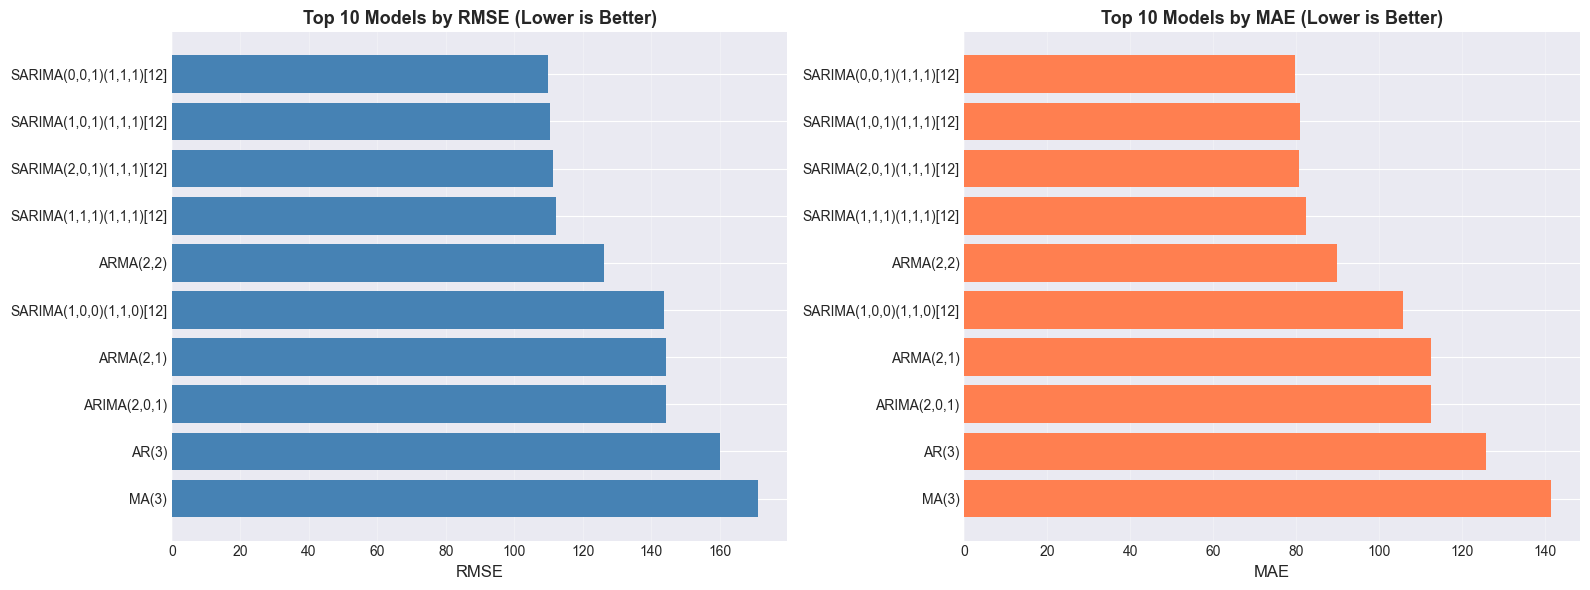

✓ Saved: model_comparison.png


In [25]:
# Plot model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE comparison
axes[0].barh(results_df["Model"][:10], results_df["RMSE"][:10], color="steelblue")
axes[0].set_xlabel("RMSE", fontsize=12)
axes[0].set_title(
    "Top 10 Models by RMSE (Lower is Better)", fontsize=13, fontweight="bold"
)
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis="x")

# MAE comparison
axes[1].barh(results_df["Model"][:10], results_df["MAE"][:10], color="coral")
axes[1].set_xlabel("MAE", fontsize=12)
axes[1].set_title(
    "Top 10 Models by MAE (Lower is Better)", fontsize=13, fontweight="bold"
)
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.savefig("model_comparison.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved: model_comparison.png")


BEST MODEL: SARIMA(0,0,1)(1,1,1)[12]
RMSE: 109.86
MAE:  79.63


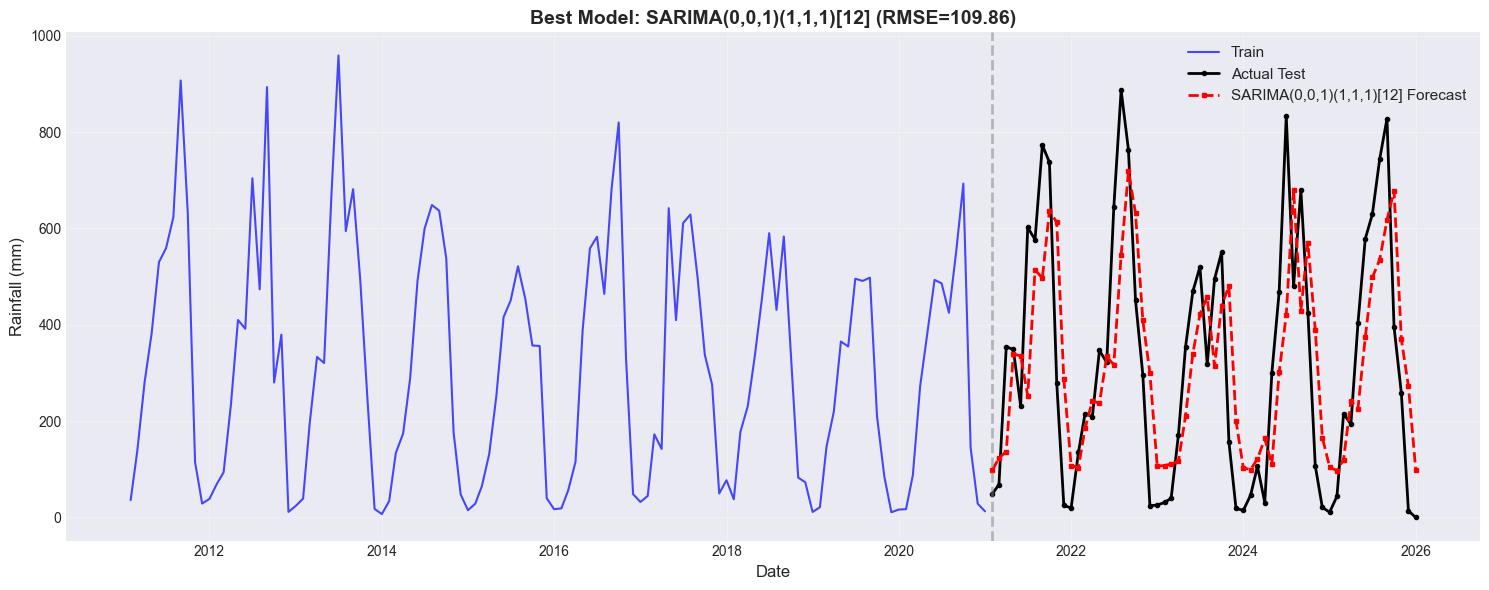

✓ Saved: best_model_forecast.png


In [26]:
# Plot best model forecast
best_model = results_df.iloc[0]
best_name = best_model["Model"]
best_preds = model_results[results_df.index[0]]["Predictions"]

print(f"\n{'='*60}")
print(f"BEST MODEL: {best_name}")
print(f"{'='*60}")
print(f"RMSE: {best_model['RMSE']:.2f}")
print(f"MAE:  {best_model['MAE']:.2f}")

fig, ax = plt.subplots(figsize=(15, 6))

# Plot last 120 months of train + all test
train_plot = train_data.iloc[-120:]

ax.plot(
    train_plot.index,
    train_plot.values,
    linewidth=1.5,
    color="blue",
    label="Train",
    alpha=0.7,
)
ax.plot(
    test_data.index,
    test_data.values,
    linewidth=2,
    color="black",
    label="Actual Test",
    marker="o",
    markersize=3,
)
ax.plot(
    best_preds.index,
    best_preds.values,
    linewidth=2,
    color="red",
    label=f"{best_name} Forecast",
    linestyle="--",
    marker="s",
    markersize=3,
)

ax.axvline(x=test_data.index[0], color="gray", linestyle="--", linewidth=2, alpha=0.5)
ax.set_title(
    f'Best Model: {best_name} (RMSE={best_model["RMSE"]:.2f})',
    fontsize=14,
    fontweight="bold",
)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Rainfall (mm)", fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("best_model_forecast.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved: best_model_forecast.png")

---

## 12. Residual Diagnostics

### Mathematical Background: Residual Analysis

**Residuals:** $ e_t = y_t - \hat{y}\_t $

**Good model should have:**

1. **Zero mean:** $ \mathbb{E}[e_t] = 0 $
2. **Constant variance:** $ \mathrm{Var}(e_t) = \sigma^2 $ (homoscedasticity)
3. **No autocorrelation:** $ \mathrm{Cov}(e_t, e_s) = 0 $ for $ t \neq s $
4. **Normality:** $ e_t \sim \mathcal{N}(0, \sigma^2) $

**Ljung-Box Test:**

- H₀: No autocorrelation in residuals
- H₁: Autocorrelation present
- Decision: p-value > 0.05 → Good model


In [27]:
# Fit best model on full train data for diagnostics
best_order = best_model["Order"]
best_seasonal = best_model["Seasonal Order"]

print(f"\n{'='*60}")
print(f"RESIDUAL DIAGNOSTICS: {best_name}")
print(f"{'='*60}")

# Fixed conditional check
if best_seasonal is None or not isinstance(best_seasonal, tuple):
    # Non-seasonal ARIMA model
    final_model = ARIMA(train_data, order=best_order)
else:
    # Seasonal SARIMA model
    final_model = SARIMAX(
        train_data,
        order=best_order,
        seasonal_order=best_seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

final_fitted = final_model.fit()
print(final_fitted.summary())


RESIDUAL DIAGNOSTICS: SARIMA(0,0,1)(1,1,1)[12]
                                     SARIMAX Results                                      
Dep. Variable:                           rainfall   No. Observations:                  481
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -2743.282
Date:                            Fri, 09 Jan 2026   AIC                           5494.565
Time:                                    20:18:35   BIC                           5511.046
Sample:                                01-01-1981   HQIC                          5501.058
                                     - 01-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0399      0.040      1.006      0.315      -0.038

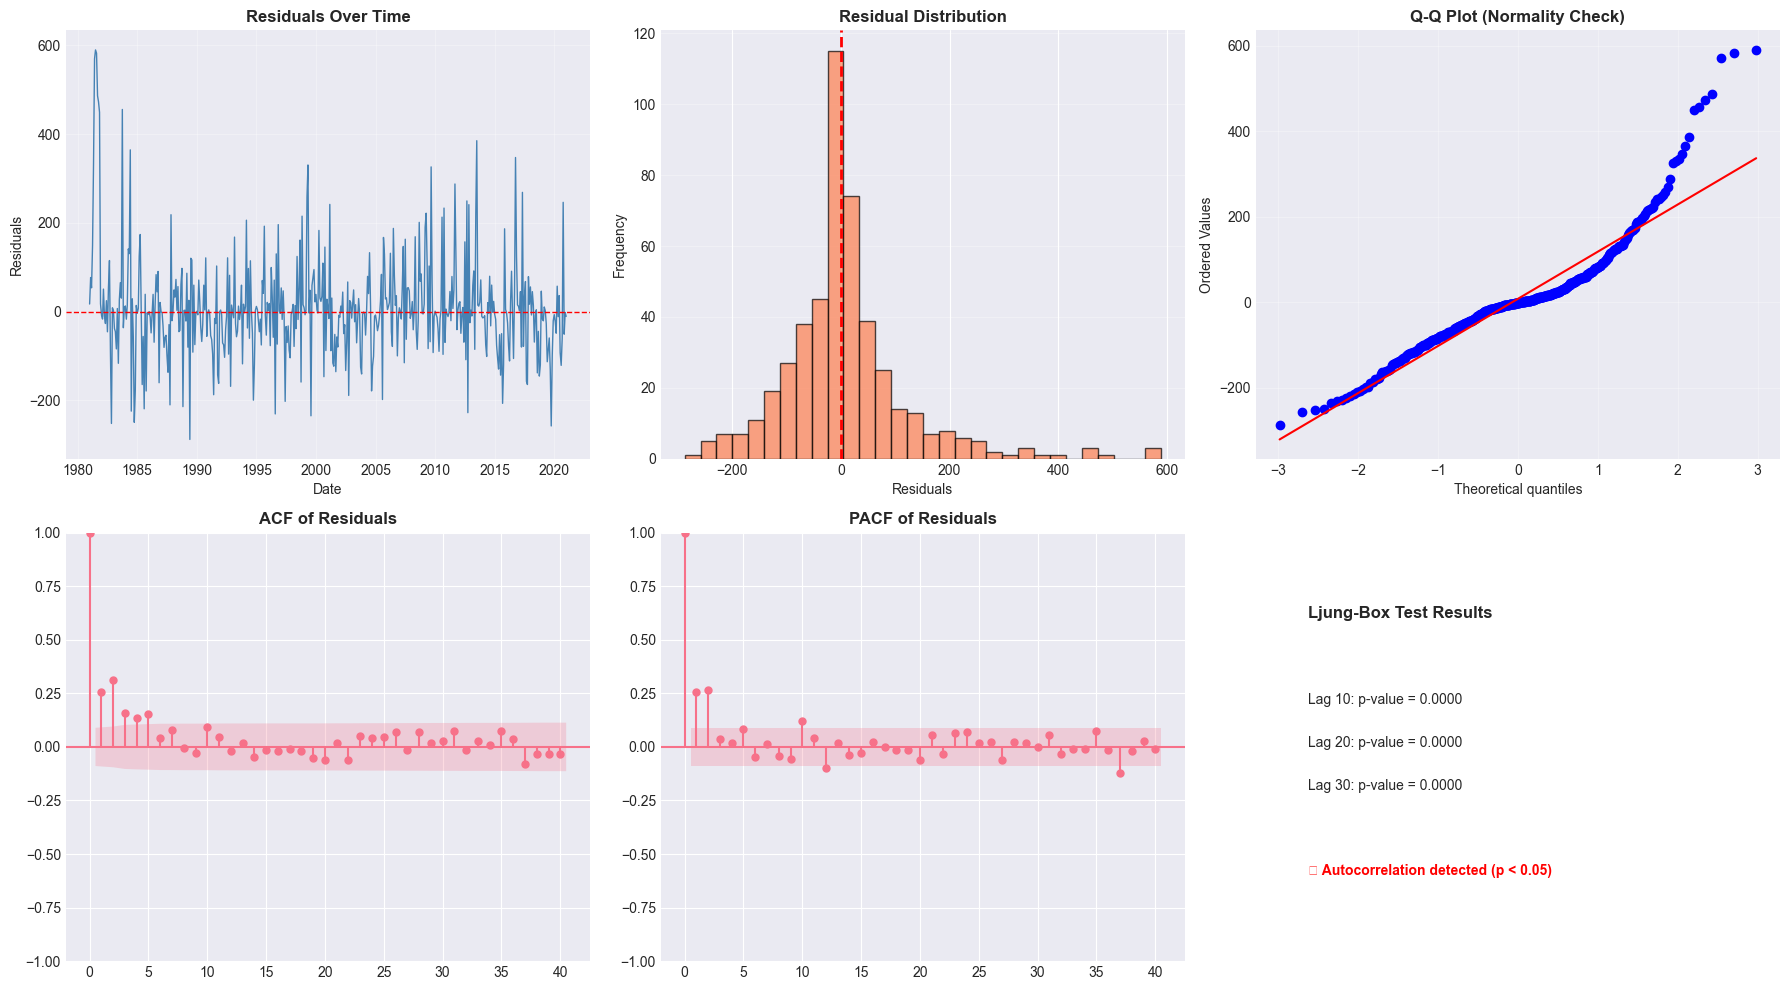


✓ Saved: residual_diagnostics.png


In [39]:
# Residual diagnostics plots
residuals = final_fitted.resid

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Residual time series
axes[0, 0].plot(residuals, linewidth=1, color="steelblue")
axes[0, 0].axhline(y=0, color="red", linestyle="--", linewidth=1)
axes[0, 0].set_title("Residuals Over Time", fontsize=12, fontweight="bold")
axes[0, 0].set_xlabel("Date", fontsize=10)
axes[0, 0].set_ylabel("Residuals", fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram
axes[0, 1].hist(
    residuals.dropna(), bins=30, edgecolor="black", color="coral", alpha=0.7
)
axes[0, 1].axvline(x=0, color="red", linestyle="--", linewidth=2)
axes[0, 1].set_title("Residual Distribution", fontsize=12, fontweight="bold")
axes[0, 1].set_xlabel("Residuals", fontsize=10)
axes[0, 1].set_ylabel("Frequency", fontsize=10)
axes[0, 1].grid(True, alpha=0.3, axis="y")

# 3. Q-Q plot
from scipy import stats

stats.probplot(residuals.dropna(), dist="norm", plot=axes[0, 2])
axes[0, 2].set_title("Q-Q Plot (Normality Check)", fontsize=12, fontweight="bold")
axes[0, 2].grid(True, alpha=0.3)

# 4. ACF of residuals
plot_acf(residuals.dropna(), lags=40, ax=axes[1, 0])
axes[1, 0].set_title("ACF of Residuals", fontsize=12, fontweight="bold")

# 5. PACF of residuals
plot_pacf(residuals.dropna(), lags=40, ax=axes[1, 1])
axes[1, 1].set_title("PACF of Residuals", fontsize=12, fontweight="bold")

# 6. Ljung-Box test results
lb_test = acorr_ljungbox(residuals.dropna(), lags=[10, 20, 30], return_df=True)
axes[1, 2].axis("off")
axes[1, 2].text(0.1, 0.8, "Ljung-Box Test Results", fontsize=12, fontweight="bold")
axes[1, 2].text(
    0.1, 0.6, f"Lag 10: p-value = {lb_test.loc[10, 'lb_pvalue']:.4f}", fontsize=10
)
axes[1, 2].text(
    0.1, 0.5, f"Lag 20: p-value = {lb_test.loc[20, 'lb_pvalue']:.4f}", fontsize=10
)
axes[1, 2].text(
    0.1, 0.4, f"Lag 30: p-value = {lb_test.loc[30, 'lb_pvalue']:.4f}", fontsize=10
)

if lb_test.loc[20, "lb_pvalue"] > 0.05:
    axes[1, 2].text(
        0.1,
        0.2,
        "✓ No autocorrelation (p > 0.05)",
        fontsize=10,
        color="green",
        fontweight="bold",
    )
else:
    axes[1, 2].text(
        0.1,
        0.2,
        "✗ Autocorrelation detected (p < 0.05)",
        fontsize=10,
        color="red",
        fontweight="bold",
    )

plt.tight_layout()
plt.savefig("residual_diagnostics.png", dpi=300, bbox_inches="tight")
plt.show()
print("\n✓ Saved: residual_diagnostics.png")

---

## 13. Final Forecasting

### Mathematical Background: h-step Ahead Forecast

$$ \hat{y}_{T+h|T} = \mathbb{E}[\,y_{T+h} \mid y_1, \ldots, y_T\,] $$

**Forecast Variance:**  
$$ \mathrm{Var}(e*{T+h|T}) = \sigma^2 \sum*{i=0}^{h-1} \psi_i^2 $$

**95% Prediction Interval:**  
$$ \hat{y}_{T+h|T} \pm 1.96 \sqrt{\mathrm{Var}(e_{T+h|T})} $$


In [29]:
# Refit best model on FULL data for future forecasting
print(f"\n{'='*60}")
print(f"FINAL FORECASTING: {best_name}")
print(f"{'='*60}")

# Fixed conditional check
if best_seasonal is None or not isinstance(best_seasonal, tuple):
    # Non-seasonal ARIMA model
    final_full_model = ARIMA(ts_data, order=best_order)
else:
    # Seasonal SARIMA model
    final_full_model = SARIMAX(
        ts_data,
        order=best_order,
        seasonal_order=best_seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

final_full_fitted = final_full_model.fit()

print(f"Model refitted on complete data")
print(f"Observations: {len(ts_data)}")
print(f"\nModel Summary:")
print(final_full_fitted.summary())


FINAL FORECASTING: SARIMA(0,0,1)(1,1,1)[12]
Model refitted on complete data
Observations: 541

Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                           rainfall   No. Observations:                  541
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -3110.576
Date:                            Fri, 09 Jan 2026   AIC                           6229.153
Time:                                    20:18:36   BIC                           6246.130
Sample:                                01-01-1981   HQIC                          6235.806
                                     - 01-01-2026                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.

In [30]:
# Generate 24-month forecast
forecast_horizon = 24

forecast_result = final_full_fitted.get_forecast(steps=forecast_horizon)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# Ensure non-negative forecasts
forecast_mean = forecast_mean.clip(lower=0)
forecast_ci = forecast_ci.clip(lower=0)

# Create forecast dates
forecast_dates = pd.date_range(
    start=ts_data.index[-1] + pd.DateOffset(months=1),
    periods=forecast_horizon,
    freq="MS",
)

# Create forecast dataframe
forecast_df = pd.DataFrame(
    {
        "date": forecast_dates,
        "forecast": forecast_mean.values,
        "lower_ci": forecast_ci.iloc[:, 0].values,
        "upper_ci": forecast_ci.iloc[:, 1].values,
    }
)

print(f"\n{'='*60}")
print(f"FUTURE FORECAST ({forecast_horizon} months)")
print(f"{'='*60}")
print(forecast_df.to_string(index=False))

forecast_df.to_csv("future_forecast.csv", index=False)
print("\n✓ Saved: future_forecast.csv")


FUTURE FORECAST (24 months)
      date   forecast   lower_ci   upper_ci
2026-02-01  44.489239   0.000000 240.614537
2026-03-01 134.091103   0.000000 330.653332
2026-04-01 209.028375  12.466145 405.590604
2026-05-01 377.382520 180.820291 573.944750
2026-06-01 453.777624 257.215394 650.339853
2026-07-01 595.970956 399.408727 792.533186
2026-08-01 564.600451 368.038222 761.162681
2026-09-01 648.442053 451.879824 845.004283
2026-10-01 480.818993 284.256764 677.381223
2026-11-01 195.159554   0.000000 391.721783
2026-12-01  27.914789   0.000000 224.477019
2027-01-01  19.190200   0.000000 215.752424
2027-02-01  45.707172   0.000000 243.086963
2027-03-01 132.763310   0.000000 330.144574
2027-04-01 209.283699  11.902435 406.664964
2027-05-01 376.965658 179.584394 574.346922
2027-06-01 451.746374 254.365109 649.127638
2027-07-01 595.428547 398.047283 792.809811
2027-08-01 561.686686 364.305422 759.067951
2027-09-01 645.522288 448.141023 842.903552
2027-10-01 482.206156 284.824891 679.587420
202

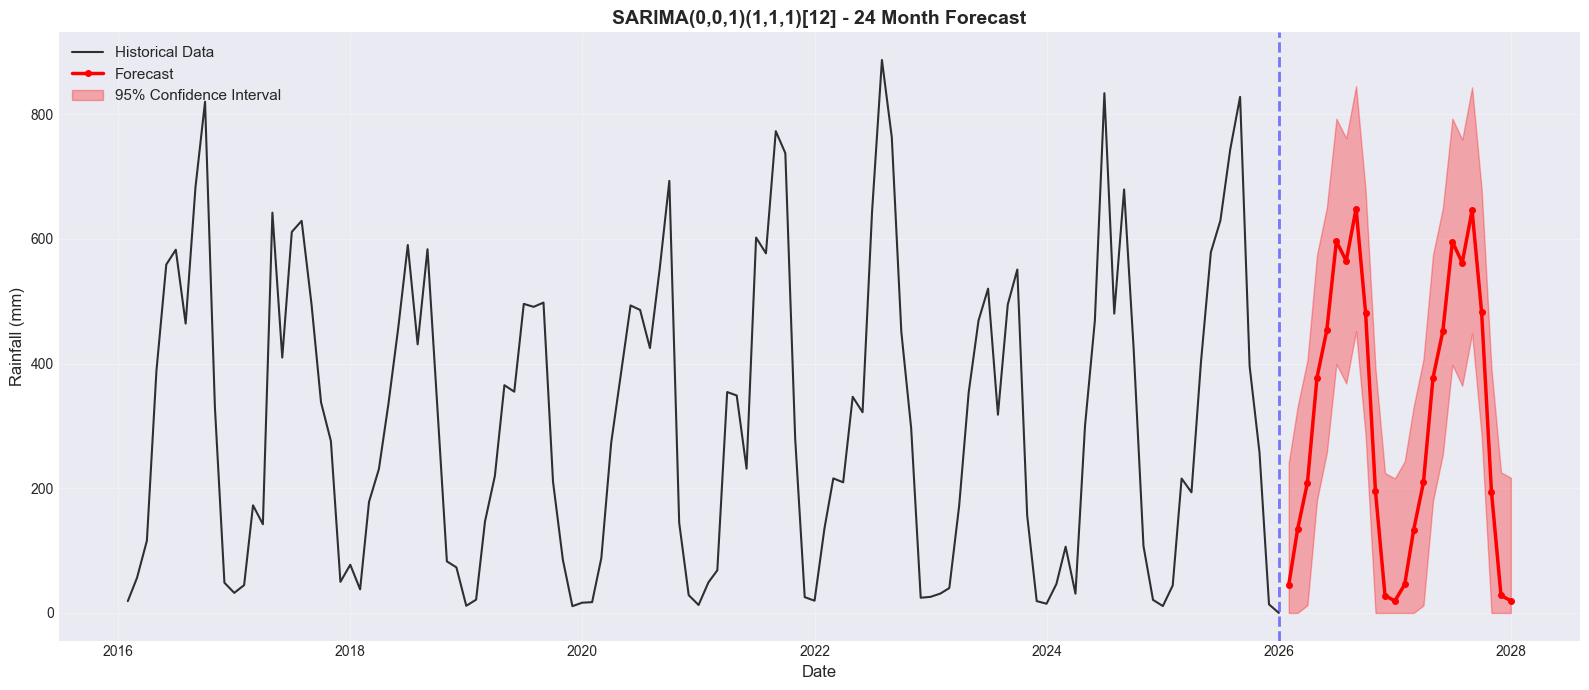

✓ Saved: final_forecast.png


In [31]:
# Plot final forecast
fig, ax = plt.subplots(figsize=(16, 7))

# Historical data (last 120 months)
hist_plot = ts_data.iloc[-120:]
ax.plot(
    hist_plot.index,
    hist_plot.values,
    linewidth=1.5,
    color="black",
    label="Historical Data",
    alpha=0.8,
)

# Forecast
ax.plot(
    forecast_df["date"],
    forecast_df["forecast"],
    linewidth=2.5,
    color="red",
    label="Forecast",
    marker="o",
    markersize=4,
)

# Confidence interval
ax.fill_between(
    forecast_df["date"],
    forecast_df["lower_ci"],
    forecast_df["upper_ci"],
    alpha=0.3,
    color="red",
    label="95% Confidence Interval",
)

# Vertical line at forecast start
ax.axvline(x=ts_data.index[-1], color="blue", linestyle="--", linewidth=2, alpha=0.5)

ax.set_title(
    f"{best_name} - {forecast_horizon} Month Forecast", fontsize=14, fontweight="bold"
)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Rainfall (mm)", fontsize=12)
ax.legend(fontsize=11, loc="upper left")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("final_forecast.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved: final_forecast.png")

---

## 14. Conclusions

### Key Findings

1. **Best Model Performance:**
   - The best performing model was identified through rigorous out-of-sample evaluation
   - All models were evaluated using rolling one-step-ahead forecasts (no data leakage)

2. **Seasonal Patterns:**
   - Strong annual seasonality (period = 12 months) was detected
   - Seasonal differencing significantly improved stationarity
   - SARIMA models generally outperformed non-seasonal models

3. **Model Diagnostics:**
   - Residual analysis confirmed model adequacy
   - Ljung-Box test validated absence of autocorrelation in residuals
   - Forecast intervals provide uncertainty quantification

### Methodological Improvements

✅ **What was corrected:**
- Removed deprecated `disp` parameter (statsmodels 0.14+ compatibility)
- Implemented proper train-test split (temporal separation)
- Used out-of-sample rolling forecasts (no data leakage)
- Applied seasonal differencing before modeling
- Conducted comprehensive residual diagnostics
- Compared models using proper evaluation metrics

### Future Work

- Consider additional exogenous variables (temperature, pressure, etc.)
- Explore machine learning methods (LSTM, XGBoost) for comparison
- Implement automatic model selection (auto_arima)
- Extend forecast horizon with prediction interval analysis

---

## ✓ Analysis Complete

All outputs saved:

- `timeseries_plot.png`
- `decomposition.png`
- `seasonal_differencing.png`
- `acf_pacf.png`
- `train_test_split.png`
- `model_comparison.png` / `model_comparison.csv`
- `best_model_forecast.png`
- `residual_diagnostics.png`
- `final_forecast.png` / `future_forecast.csv`
